In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
#all a single example session

results_paths={}

# results_paths['context']="s3://aind-scratch-data/dynamic-routing/decoding/results/test_0.05s_multi_timebin_0/"
results_paths['context_baseline_subtract'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtracted_0/"
# results_paths['response'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_0/"
# results_paths['response_baseline_subtract'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_baseline_subtracted_1/"

# results_paths['context_baseline_subtract_vis1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_vis1_only_0/"
# results_paths['context_baseline_subtract_sound1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_sound1_only_0/"

# results_paths['response_baseline_subtract_vis1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_vis1_only_baseline_subtract_20250827_174517/"
# results_paths['response_baseline_subtract_sound1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_sound1_only_baseline_subtract_20250827_174716/"

# results_paths['response_baseline_subtract_unrewarded_target'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_unrewarded_target_baseline_subtract_20250827_224845/"

# results_paths['response_baseline_subtract_sound1_vis_context'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_sound1_in_vis_context_baseline_subtract_20250827_223700/"

results_paths['context_baseline_subtract_cumulative_0.01'] ="s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_181812/"
results_paths['context_baseline_subtract_cumulative_0.02'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_185213/"
results_paths['context_baseline_subtract_cumulative_0.05'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_193324/"
results_paths['context_cumulative_0.05'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_all_units_20250829_194357/"


# results_paths['context_baseline_subtract_cumulative_0.01'] = ""

results_paths['context_baseline_subtract_0.01_step_0.05_window'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_100ms_step_500ms_sliding_window_20250829_220312/"

# results_paths['context_baseline_subtract_0.01_step_previous_0.05_window'] = ""

In [91]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_engaged')
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [92]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}



In [127]:
# session-wise average decoding accuracy

def get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping):

    new_results_session_df = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').is_in(dr_session_list),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').not_(),
        )
        #get total n units
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                )
                #make new rows according to structure_grouping
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                    .then(pl.col('structure').repeat_by(n_repeats))
                    .otherwise(pl.col('structure').repeat_by(1))
                )
                .explode('structure')
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                    .then(pl.col('structure').replace(structure_grouping))
                    .otherwise(pl.col('structure'))
                )
                .group_by('session_id','structure')
                .agg(
                    pl.col('unit_id').len().alias('total_n_units')
                )
            ),
            on=['session_id','structure'],
            how='left',
        )
        #join on session table to get cross-modal dprime, etc.
        .join(
            other=session_table.filter(
                pl.col('session_id').is_in(dr_session_list)
            ).select(
                'session_id',
                'n_passing_blocks',
                'cross_modality_dprime_vis_blocks',
                'cross_modality_dprime_aud_blocks',
            ).lazy(),
            on='session_id',
            how='left',
        )
        # get the means for each recording over repeats:
        .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
        .agg(
            pl.col('balanced_accuracy_test').mean(), # over repeats
        )
        # get the aligned result and median over shifts:
        .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                            'cross_modality_dprime_aud_blocks', 'total_n_units'})
        .agg(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
            pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
        )
        # get the difference between true and null:
        .with_columns(
            pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
        )
        .sort('structure', 'unit_subsample_size', descending=False)
        .collect()
    )

    return new_results_session_df.to_pandas()

In [172]:
results_dfs={}
for key, results_path in results_paths.items():
    print(f"Loading results from {key}...")
    results_dfs[key] = get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping)

Loading results from context_baseline_subtract...
Loading results from context_baseline_subtract_cumulative_0.01...
Loading results from context_baseline_subtract_cumulative_0.02...
Loading results from context_baseline_subtract_cumulative_0.05...
Loading results from context_cumulative_0.05...
Loading results from context_baseline_subtract_0.01_step_0.05_window...


In [95]:
results_dfs[key]['structure'].unique()

array(['ACAd', 'ACAv', 'CP', 'FRP', 'ILA', 'MOs', 'ORBl', 'PAG', 'RSPagl',
       'RSPd', 'RSPv', 'SCig', 'SCm', 'SCs', 'SSp', 'VISam', 'VPL', 'VPM'],
      dtype=object)

In [159]:
np.sort(results_dfs[key]['bin_center'].unique())*2

array([-0.165, -0.155, -0.145, -0.135, -0.125, -0.115, -0.105, -0.095,
       -0.085, -0.075, -0.065, -0.055, -0.045, -0.035, -0.025, -0.015,
       -0.005,  0.005,  0.015,  0.025,  0.035,  0.045,  0.055,  0.065,
        0.075,  0.085,  0.095,  0.105,  0.115,  0.125,  0.135,  0.145,
        0.155,  0.165,  0.175,  0.185,  0.195,  0.205,  0.215,  0.225,
        0.235,  0.245,  0.255,  0.265,  0.275,  0.285,  0.295,  0.305,
        0.315,  0.325,  0.335,  0.345,  0.355,  0.365,  0.375,  0.385,
        0.395,  0.405,  0.415,  0.425,  0.435,  0.445,  0.455,  0.465,
        0.475,  0.485,  0.495,  0.505,  0.515,  0.525])

Plotting results from context_baseline_subtract...
Plotting results from context_baseline_subtract_cumulative_0.01...
Plotting results from context_baseline_subtract_cumulative_0.02...
Plotting results from context_baseline_subtract_cumulative_0.05...
Plotting results from context_cumulative_0.05...
Plotting results from context_baseline_subtract_0.01_step_0.05_window...


Text(0.5, 1.0, '664851_2023-11-13; PAG; stim_start_time; 20 units')

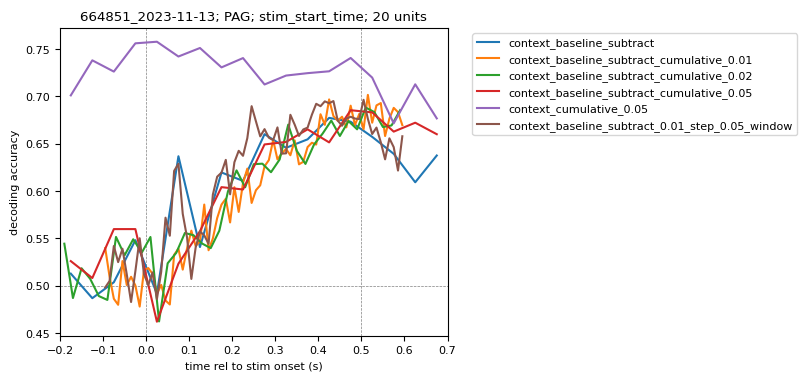

In [176]:

sel_session="664851_2023-11-13"

sel_structure="PAG"
# sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

for key, new_results_session_pd in results_dfs.items():
    print(f"Plotting results from {key}...")

    example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="{sel_time_aligned_to}" ').sort_values('bin_center')
    # if key=='context_baseline_subtract_cumulative_0.01':
    #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
    # else:
    ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label=key)

# ax.set_ylim(0.5,1)

ax.set_xlim(-0.2,0.7)
ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
#place legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [119]:
# (example_timebin_decoding['bin_center']*2+.095).values
key

'context_baseline_subtract_cumulative_0.01'

In [89]:

sel_session="664851_2023-11-13"

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\test_baseline_subtraction_and_lick_decoding_2025-08-28"

sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"

unique_structures=results_dfs[key]['structure'].unique()

sel_results_to_plot = [
    ['context', 'context_baseline_subtract'],
    ['response', 'response_baseline_subtract'],
    ['context_baseline_subtract','response_baseline_subtract'],
    ['context_baseline_subtract', 'context_baseline_subtract_vis1_only', 'context_baseline_subtract_sound1_only'],
    ['response_baseline_subtract', 'response_baseline_subtract_vis1_only', 'response_baseline_subtract_sound1_only'],
    ['context_baseline_subtract_vis1_only', 'response_baseline_subtract_vis1_only',],
    ['context_baseline_subtract_sound1_only', 'response_baseline_subtract_sound1_only',],
]

for sel_structure in unique_structures:
    plot_idx=0
    for results_to_plot in sel_results_to_plot:

        fig,ax=plt.subplots(1,1,figsize=(5,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        for key in results_to_plot:
            new_results_session_pd = results_dfs[key]

            example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')

            linestyle='-'
            if 'vis' in key:
                color='tab:green'
                if 'response' in key:
                    linestyle='--'
            elif 'sound' in key:
                color='tab:pink'
                if 'response' in key:
                    linestyle='--'
            elif key=="context" or key=="response":
                color='k'
            elif key=='context_baseline_subtract':
                color='tab:blue'
            elif key=='response_baseline_subtract':
                color='tab:orange'

            ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label=key, color=color, linestyle=linestyle)

        # ax.set_ylim(0.5,1)

        ax.set_xlim(-0.2,0.7)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

        fig.savefig(os.path.join(savepath, f"{sel_session}_{sel_structure}_{sel_unit_subsample_size}units_"+str(plot_idx)+ ".png"), 
                    bbox_inches='tight',dpi=300)
        plt.close(fig)

        plot_idx+=1

